This notebook reproduces [experimental results](https://iopscience.iop.org/article/10.1088/1402-4896/ab60f9/meta) on D retention in W exposed to impulse plasma load in QSPA-T.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pypalettes import load_cmap

mpl_params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
            r"\usepackage{amsmath}",
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[russian]{babel}",
        ]
    ),
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.family": "Times New Roman",
    "font.size": 12,
    "legend.frameon": False,
}

plt.rcParams.update(mpl_params)
mm2inch = 1e-1 / 2.54

## Heat pulse

Fitting parameters: [3.98024781e-05 6.13224680e-04 2.34732886e-05 2.14871056e-01
 2.35586767e-04], integral = 7.72843e-04 s


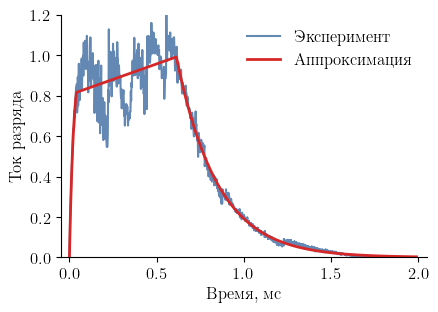

In [2]:
from scipy.optimize import curve_fit

cmap = load_cmap("Superfishel_Stone", cmap_type="discrete")


def fit_func(t, t1, t2, dt1, delta, dt2):
    """
    This function defines a trapezoid-like pulse with exponential leading and trailing edges

    :param t: time
    :type t: s
    """

    return np.piecewise(
        t,
        [t <= t1, (t > t1) & (t <= t2), t > t2],
        [
            lambda t: (1 - np.exp(-t / dt1)),
            lambda t: (1 - np.exp(-t1 / dt1)) * (1 + delta * (t - t1) / (t2 - t1)),
            lambda t: (1 - np.exp(-t1 / dt1)) * (1 + delta) * np.exp(-(t - t2) / dt2),
        ],
    )


QSPA_pulse = np.loadtxt("./reference_data/QSPA_pulse.txt", delimiter=" ", skiprows=1)

popt, _ = curve_fit(
    fit_func,
    QSPA_pulse[:, 0],
    QSPA_pulse[:, 1],
    p0=[1.73891412e-05, 6.01227240e-04, 3.31805703e-06, 3.53224724e-01, 2.55841858e-04],
)

times = np.linspace(0, 5e-3, 100000)
integral = np.trapz(fit_func(times, *popt), x=times)
print(f"Fitting parameters: {popt}, integral = {integral:.5e} s")

plt.figure(figsize=(120 * mm2inch, 80 * mm2inch))

plt.plot(
    QSPA_pulse[:, 0] / 1e-3,
    QSPA_pulse[:, 1],
    lw=1.5,
    color=cmap(0),
    label="Эксперимент",
)
plt.plot(
    QSPA_pulse[:, 0] / 1e-3,
    fit_func(QSPA_pulse[:, 0], *popt),
    lw=2,
    color="tab:red",
    label="Аппроксимация",
)
plt.ylabel("Ток разряда")
plt.xlabel("Время, мс")
plt.xlim(-0.05, 2.05)
plt.ylim(0, 1.2)
plt.legend()

plt.savefig(
    "../../../Thesis/images/QSPA_pulse.pdf", bbox_inches="tight", pad_inches=0.02
)
plt.show()

## FESTIM model with kinetic surface model

In [13]:
import festim as F
import numpy as np
import matplotlib.pyplot as plt
from sub_functions.materials import W
from sub_functions.custom_classes import CustomHeatSolver, CustomHeatSource
import sympy as sp
import fenics as f
from scipy import special


def custom_exp(x):
    if isinstance(x, np.ndarray):
        return np.exp(x)
    else:
        return f.exp(x)


def normal_distr(X, sigma):
    """
    :param X: Range
    :type X: float
    :param sigma: Width
    :type sigma: float
    """
    return 2 / (
        special.erf((L - X) / np.sqrt(2) / sigma) + special.erf(X / np.sqrt(2) / sigma)
    )


def q_heat(t):
    E0 = 0.7e6

    t1 = 3.98024781e-05
    t2 = 6.13224680e-04
    dt1 = 2.34732886e-05
    delta = 2.14871053e-01
    dt2 = 2.35586767e-04
    norm = 7.72843e-04

    f1 = lambda t: (1 - sp.exp(-t / dt1))
    f2 = lambda t: (1 + delta * (t - t1) / (t2 - t1))
    f3 = lambda t: sp.exp(-(t - t2) / dt2)

    return (
        E0
        * sp.Piecewise(
            (f1(t), t <= t1),
            (f1(t1) * f2(t), (t > t1) & (t <= t2)),
            (f1(t1) * f2(t2) * f3(t), True),
        )
        / norm
    )


def q_rad(T, mobile):
    return -alpha_W * sigma * (T**4 - T0**4)


alpha_W = 0.4  # W emissivity
sigma = 5.67e-8  # Stefan-Boltzmann constant
T0 = 300  # Initial temperature, K
L = 2e-3  # Geometry length, m

vertices = np.concatenate(
    [
        np.linspace(0, 1e-6, 500),
        np.linspace(1e-6, 10e-6, 500),
        np.linspace(10e-6, 100e-6, 500),
        np.linspace(100e-6, L, 250),
    ]
)

R_impl = 1.46e-9  # 11.09e-10 #
sigma_impl = 0.81e-9  # 6.34e-10 #
r = 0.74  # 0.78 #
final_time = 1e4

ramp = 2
start_TDS_time = 0
TDS_time = 750

In [4]:
def run_surface_model(k_loss, is_TDS=False):

    def heat_loss(T):
        return -k_loss * W().thermal_cond_function(T) * (T - T0)

    ############ EXPOSURE
    E_dt1 = 1.406
    E_dt2 = 1.859
    eta1 = 0.788e-5
    eta2 = 0.212e-5
    Ec = 0

    model = F.Simulation()

    model.mesh = F.MeshFromVertices(vertices=vertices)

    mat = W()

    model.materials = F.Material(
        id=1,
        D_0=mat.D_0,
        E_D=mat.E_diff,
        thermal_cond=mat.thermal_cond_function,
        rho=mat.rho,
        heat_capacity=mat.heat_capacity_function,
        Q=mat.heat_of_transport_function,
    )

    trap1 = F.Trap(
        k_0=mat.nu_D / mat.n_IS,
        E_k=mat.E_diff,
        p_0=mat.nu_0,
        E_p=E_dt1,
        density=eta1 * mat.n_mat,
        materials=model.materials[0],
    )

    trap2 = F.Trap(
        k_0=mat.nu_D / mat.n_IS,
        E_k=mat.E_diff,
        p_0=mat.nu_0,
        E_p=E_dt2,
        density=eta2 * mat.n_mat,
        materials=model.materials[0],
    )

    model.traps = [trap1, trap2]

    model.sources = [
        CustomHeatSource(function=heat_loss, field="T", volume=1),
        F.ImplantationFlux(
            flux=q_heat(F.t)
            * 7.72843e-04
            / 0.7e6
            * 7.5e26
            * normal_distr(R_impl, sigma_impl)
            * (1 - r),
            imp_depth=R_impl,
            width=sigma_impl,
            volume=1,
        ),
    ]

    def Qc(cs):
        theta = cs / mat.n_surf

        return -(1.062152 / (1 + custom_exp((theta - 0.58) / 0.0262)))

    def k_sb(T, cs, cm):
        return mat.nu_0 * f.exp(-(mat.E_diff + mat.Q_s - Qc(cs)) / F.k_B / T)

    def k_bs(T, cs, cm):
        return mat.nu_D * mat.lambda_abs * f.exp(-mat.E_diff / F.k_B / T)

    def J_vs(T, cs, cm):

        J_des = (
            2
            * mat.nu_0
            * cs**2
            / mat.n_surf
            * custom_exp(-2 * (Ec - Qc(cs)) / F.k_B / T)
        )

        return -J_des

    BC_left = F.SurfaceKinetics(
        k_sb=k_sb,
        k_bs=k_bs,
        lambda_IS=mat.lambda_IS,
        n_surf=mat.n_surf,
        n_IS=mat.n_IS,
        J_vs=J_vs,
        surfaces=1,
        initial_condition=0,
    )

    model.boundary_conditions = [
        F.DirichletBC(surfaces=2, value=0, field=0),
        BC_left,
        F.FluxBC(surfaces=1, value=q_heat(F.t), field="T"),
        F.CustomFlux(surfaces=[1, 2], function=q_rad, field="T"),
    ]

    model.T = CustomHeatSolver(
        transient=True,
        initial_condition=T0,
        absolute_tolerance=1.0,
        relative_tolerance=1e-3,
    )

    def dt(t):
        if t < 5e-3:
            return 2e-5
        elif t < 1:
            return 0.1
        else:
            return 1000

    model.dt = F.Stepsize(
        initial_value=1e-9,
        max_stepsize=dt,
        dt_min=1e-9,
        stepsize_change_ratio=1.05,
        milestones=[final_time],
    )

    model.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-10,
        transient=True,
        final_time=final_time,
        maximum_iterations=30,
        soret=True,
        traps_element_type="DG",
    )

    derived_quantities_exposure = F.DerivedQuantities(
        [
            F.TotalVolume(field="retention", volume=1),
            F.TotalSurface(field="T", surface=1),
            F.TotalSurface(field="T", surface=2),
            F.AdsorbedHydrogen(surface=1),
        ],
        filename="./results_surface_model/derived_quantities_exposure.csv",
    )

    TXT_exposure = [
        F.TXTExport(
            field="retention",
            filename="./results_surface_model//retention.txt",
            times=[final_time],
            write_at_last=True,
        ),
    ]

    XDMF_exposure = [
        F.XDMFExport(
            field=0,
            label="mobile",
            filename="results_surface_model/mobile.xdmf",
            checkpoint=True,
            mode="last",
        ),
        F.XDMFExport(
            field="1",
            label="trap1",
            filename="results_surface_model/trap1.xdmf",
            checkpoint=True,
            mode="last",
        ),
        F.XDMFExport(
            field="2",
            label="trap2",
            filename="results_surface_model/trap2.xdmf",
            checkpoint=True,
            mode="last",
        ),
    ]

    model.exports = [derived_quantities_exposure] + TXT_exposure + XDMF_exposure

    model.initialise()
    model.run()

    derived_quantities_TDS = None
    if is_TDS:
        ############ TDS

        model_TDS = F.Simulation()

        model_TDS.mesh = F.MeshFromVertices(vertices=vertices)

        model_TDS.materials = F.Material(
            id=1,
            D_0=mat.D_0,
            E_D=mat.E_diff,
        )

        model_TDS.traps = model.traps

        BC_left.initial_condition = derived_quantities_exposure[-1].data[-1]

        model_TDS.boundary_conditions = [
            F.DirichletBC(surfaces=[2], value=0, field=0),
            BC_left,
        ]

        model_TDS.initial_conditions = [
            F.InitialCondition(
                field=0,
                value="./results_surface_model/mobile.xdmf",
                label="mobile",
                time_step=-1,
            ),
            F.InitialCondition(
                field="1",
                value="./results_surface_model/trap1.xdmf",
                label="trap1",
                time_step=-1,
            ),
            F.InitialCondition(
                field="2",
                value="./results_surface_model/trap2.xdmf",
                label="trap2",
                time_step=-1,
            ),
        ]

        T_value = sp.Piecewise(
            (
                T0 + ramp * (F.t - start_TDS_time),
                F.t >= start_TDS_time,
            ),  # increase temp after sometime
            (T0, True),  # otherwise T=300.1
        )
        model_TDS.T = F.Temperature(value=T_value)

        model_TDS.dt = F.Stepsize(
            initial_value=1e-6,
            max_stepsize=1,
            dt_min=1e-8,
            stepsize_change_ratio=1.2,
        )

        model_TDS.settings = F.Settings(
            absolute_tolerance=1e10,
            relative_tolerance=1e-10,
            transient=True,
            final_time=start_TDS_time + TDS_time,
            maximum_iterations=60,
        )

        derived_quantities_TDS = F.DerivedQuantities(
            [
                F.HydrogenFlux(surface=1),
                F.TotalSurface(field="T", surface=1),
                F.TotalVolume(field="retention", volume=1),
                F.TotalVolume(field="1", volume=1),
                F.TotalVolume(field="2", volume=1),
                F.AdsorbedHydrogen(surface=1),
                F.HydrogenFlux(surface=2),
            ],
            filename="./results_surface_model/derived_quantities_TDS.csv",
        )

        model_TDS.exports = [derived_quantities_TDS]

        model_TDS.initialise()
        model_TDS.run()

    if derived_quantities_TDS is not None:
        return TXT_exposure, derived_quantities_exposure, derived_quantities_TDS, J_vs
    else:
        return TXT_exposure, derived_quantities_exposure, J_vs

## FESTIM model with recombinative BC

In [14]:
def run_recombination_model(k_loss, E_c):

    def heat_loss(T):
        return -k_loss * W().thermal_cond_function(T) * (T - T0)

    def K_PS(T, mobile):
        Kr_0 = 3e-25  # T^0.5*m^4/s
        Er = 1.03  # 2.06
        return -Kr_0 * T ** (-0.5) * f.exp(2 * (Er - E_c) / F.k_B / T) * mobile**2

    ############ EXPOSURE
    E_dt1 = 1.5
    eta1 = 1e-5

    model = F.Simulation()

    model.mesh = F.MeshFromVertices(vertices=vertices)

    mat = W()

    model.materials = F.Material(
        id=1,
        D_0=mat.D_0,
        E_D=mat.E_diff,
        thermal_cond=mat.thermal_cond_function,
        rho=mat.rho,
        heat_capacity=mat.heat_capacity_function,
        Q=mat.heat_of_transport_function,
    )

    trap1 = F.Trap(
        k_0=mat.nu_D / mat.n_IS,
        E_k=mat.E_diff,
        p_0=mat.nu_0,
        E_p=E_dt1,
        density=eta1 * mat.n_mat,
        materials=model.materials[0],
    )

    model.traps = [trap1]

    model.sources = [
        CustomHeatSource(function=heat_loss, field="T", volume=1),
        F.ImplantationFlux(
            flux=q_heat(F.t)
            * 7.72843e-04
            / 0.7e6
            * 7.5e26
            * normal_distr(R_impl, sigma_impl)
            * (1 - r),
            imp_depth=R_impl,
            width=sigma_impl,
            volume=1,
        ),
    ]

    BC_left = F.CustomFlux(function=K_PS, field="solute", surfaces=1)

    model.boundary_conditions = [
        F.DirichletBC(surfaces=2, value=0, field=0),
        BC_left,
        F.FluxBC(surfaces=1, value=q_heat(F.t), field="T"),
        F.CustomFlux(surfaces=[1, 2], function=q_rad, field="T"),
    ]

    model.T = CustomHeatSolver(
        transient=True,
        initial_condition=T0,
        absolute_tolerance=1.0,
        relative_tolerance=1e-3,
    )

    def dt(t):
        if t < 5e-3:
            return 2e-5
        elif t < 1:
            return 0.1
        else:
            return 1000

    model.dt = F.Stepsize(
        initial_value=1e-9,
        max_stepsize=dt,
        dt_min=1e-9,
        stepsize_change_ratio=1.05,
        milestones=[final_time],
    )

    model.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-10,
        transient=True,
        final_time=final_time,
        maximum_iterations=30,
        soret=True,
        traps_element_type="DG",
    )

    derived_quantities_exposure = F.DerivedQuantities(
        [
            F.TotalVolume(field="retention", volume=1),
            F.TotalSurface(field="T", surface=1),
            F.TotalSurface(field="T", surface=2),
        ],
        filename="./results_recombination/test.csv",
    )

    TXT_exposure = [
        F.TXTExport(
            field="retention",
            filename="./results_recombination//retention.txt",
            times=[final_time],
            write_at_last=True,
        ),
    ]

    XDMF_exposure = [
        F.XDMFExport(
            field=0,
            label="mobile",
            filename="results_recombination/mobile.xdmf",
            checkpoint=True,
            mode="last",
        ),
        F.XDMFExport(
            field="1",
            label="trap1",
            filename="results_recombination/trap1.xdmf",
            checkpoint=True,
            mode="last",
        ),
    ]

    model.exports = [derived_quantities_exposure] + TXT_exposure + XDMF_exposure

    model.initialise()
    model.run()

    ############ TDS
    model_TDS = F.Simulation()

    model_TDS.mesh = F.MeshFromVertices(vertices=vertices)

    model_TDS.materials = F.Material(
        id=1,
        D_0=mat.D_0,
        E_D=mat.E_diff,
    )

    model_TDS.traps = model.traps

    BC_left.initial_condition = derived_quantities_exposure[-1].data[-1]

    model_TDS.boundary_conditions = [
        F.DirichletBC(surfaces=[2], value=0, field=0),
        BC_left,
    ]

    model_TDS.initial_conditions = [
        F.InitialCondition(
            field="1",
            value="./results_recombination/trap1.xdmf",
            label="trap1",
            time_step=-1,
        ),
    ]

    T_value = sp.Piecewise(
        (
            T0 + ramp * (F.t - start_TDS_time),
            F.t >= start_TDS_time,
        ),  # increase temp after sometime
        (T0, True),  # otherwise T=300.1
    )
    model_TDS.T = F.Temperature(value=T_value)

    model_TDS.dt = F.Stepsize(
        initial_value=1e-6,
        max_stepsize=1,
        dt_min=1e-8,
        stepsize_change_ratio=1.2,
    )

    model_TDS.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-10,
        transient=True,
        final_time=start_TDS_time + TDS_time,
        maximum_iterations=60,
    )

    derived_quantities_TDS = F.DerivedQuantities(
        [
            F.HydrogenFlux(surface=1),
            F.TotalSurface(field="T", surface=1),
            F.TotalVolume(field="retention", volume=1),
            F.TotalVolume(field="1", volume=1),
            F.HydrogenFlux(surface=2),
        ],
        filename="./results_recombination/derived_quantities_TDS.csv",
    )

    model_TDS.exports = [derived_quantities_TDS]

    model_TDS.initialise()
    model_TDS.run()

    return TXT_exposure, derived_quantities_exposure, derived_quantities_TDS

## TDS

In [8]:
(
    txt_data_exposure_SM,
    derived_quantities_exposure_SM,
    derived_quantities_TDS_SM,
    J_vs,
) = run_surface_model(0, True)
txt_data_exposure_R, derived_quantities_exposure_R, derived_quantities_TDS_R = (
    run_recombination_model(0, 0.83)
)

Defining variational problem heat transfers
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+04 s    Elapsed time so far: 71.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/xdmf_export.py:132: UserWarning: in 1D, checkpoint needs to be set to False to visualise the XDMF file in Paraview (see issue https://github.com/festim-dev/festim/issues/134)
  warnings.warn(msg)


100.0 %        7.5e+02 s    Elapsed time so far: 45.5 s
Defining variational problem heat transfers
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+04 s    Elapsed time so far: 53.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        7.5e+02 s    Elapsed time so far: 23.9 s


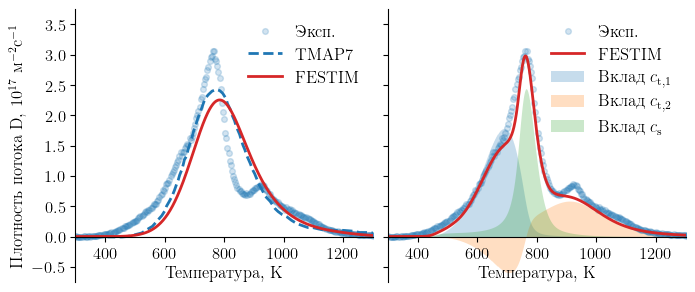

In [9]:
fig, axs = plt.subplots(
    1, 2, figsize=(200 * mm2inch, 90 * mm2inch), sharey=True, sharex=True
)

exp_TDS = np.loadtxt("./reference_data/TDS_07MJ.txt", delimiter=" ", skiprows=1)
for ax in axs:
    ax.scatter(
        exp_TDS[:, 0],
        exp_TDS[:, 1] * 1e4 / 1e17,
        s=17,
        alpha=0.2,
        zorder=-1,
        label="Эксп.",
    )
    ax.spines["bottom"].set_position(("data", 0))

TMAP_data = np.loadtxt("./reference_data/Poskakalov_sim.csv", skiprows=1, delimiter=",")
TMAP_data = TMAP_data[TMAP_data[:, 0].argsort()]
axs[0].plot(TMAP_data[:, 0], TMAP_data[:, 1] / 1e17, ls="dashed", lw=2, label="TMAP7")

####### Model with recombination BC
t = np.array(derived_quantities_TDS_R.t)
flux = -np.array(derived_quantities_TDS_R[0].data)
T = np.array(derived_quantities_TDS_R[1].data)
trap1_data = np.array(derived_quantities_TDS_R[3].data)

dtr1 = -np.diff(trap1_data) / np.diff(t)

axs[0].plot(T, flux / 1e17, label="FESTIM", color="tab:red", lw=2)

####### Model with SK BC
t = np.array(derived_quantities_TDS_SM.t)
# flux = -np.array(derived_quantities_TDS_SM[0].data)-np.array(derived_quantities_TDS_SM[-1].data)
T = np.array(derived_quantities_TDS_SM[1].data)
cs_data = np.array(np.array(derived_quantities_TDS_SM[-2].data))
trap1_data = np.array(derived_quantities_TDS_SM[3].data)
trap2_data = np.array(derived_quantities_TDS_SM[4].data)

dtr1 = -np.diff(trap1_data) / np.diff(t)
dtr2 = -np.diff(trap2_data) / np.diff(t)
dcs = -np.diff(cs_data) / np.diff(t)

axs[1].plot(T, -J_vs(T, cs_data, _) / 1e17, label="FESTIM", color="tab:red", lw=2)
axs[1].fill_between(
    T[1:],
    np.zeros_like(dtr1),
    dtr1 / 1e17,
    alpha=0.25,
    lw=0,
    zorder=-2,
    label=r"Вклад $c_{\mathrm{t,1}}$",
    color="tab:blue",
)
axs[1].fill_between(
    T[1:],
    np.zeros_like(dtr2),
    dtr2 / 1e17,
    alpha=0.25,
    lw=0,
    zorder=-2,
    label=r"Вклад $c_{\mathrm{t,2}}$",
    color="tab:orange",
)
axs[1].fill_between(
    T[1:],
    np.zeros_like(dtr2),
    dcs / 1e17,
    alpha=0.25,
    lw=0,
    zorder=-2,
    label=r"Вклад $c_\mathrm{s}$",
    color="tab:green",
)


axs[1].set_xlim(300, 1300)
axs[1].set_xticks([i for i in range(400, 1400, 200)])
axs[1].set_yticks([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])
axs[0].set_ylabel(r"Плотность потока D, $10^{17}$ м$^{-2}$с$^{-1}$")
axs[0].set_xlabel(r"Температура, К")
axs[1].set_xlabel(r"Температура, К")
axs[0].legend()
axs[1].legend()
axs[1].set_ylim(-0.75, 3.75)

fig.subplots_adjust(wspace=0.05)

plt.savefig("../../../Thesis/images/QSPA_TDS.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()

## Concentration profiles

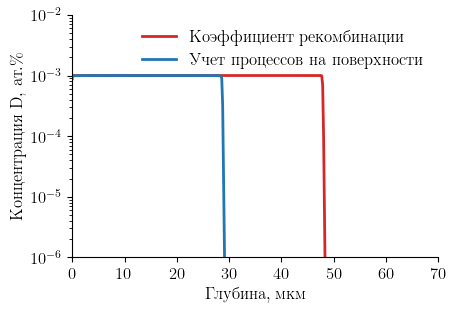

In [9]:
plt.figure(figsize=(120 * mm2inch, 80 * mm2inch))

mat = W()


plt.plot(
    txt_data_exposure_R[0].data[:, 0] / 1e-6,
    txt_data_exposure_R[0].data[:, -1] / mat.n_mat * 100,
    color="tab:red",
    label="Коэффициент рекомбинации",
    lw=2,
)
plt.plot(
    txt_data_exposure_SM[0].data[:, 0] / 1e-6,
    txt_data_exposure_SM[0].data[:, -1] / mat.n_mat * 100,
    color="tab:blue",
    label="Учет процессов на поверхности",
    lw=2,
)

plt.yscale("log")
plt.xlim(0, 70)
plt.ylim(1e-6, 1e-2)
plt.ylabel(r"Концентрация D, ат.\%")
plt.xlabel(r"Глубина, мкм")
plt.legend()

plt.savefig(
    "../../../Thesis/images/QSPA_conc.pdf", bbox_inches="tight", pad_inches=0.02
)
plt.show()

## Temperature evolution

In [15]:
dq_results = []
TXT_results = []
for k_loss in [0, 1.2e3]:
    txt_data, derived_quantities, _ = run_surface_model(k_loss, False)
    dq_results.append(derived_quantities)
    TXT_results.append(txt_data)

dq_results1 = []
TXT_results = []
for k_loss in [0, 1.2e3]:
    txt_data_exposure_R, derived_quantities_exposure_R, derived_quantities_TDS_R = (
        run_recombination_model(k_loss, 0.83)
    )
    dq_results1.append(derived_quantities_exposure_R)
    TXT_results.append(txt_data)

Defining variational problem heat transfers
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+04 s    Elapsed time so far: 64.5 s
Defining variational problem heat transfers
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/xdmf_export.py:132: UserWarning: in 1D, checkpoint needs to be set to False to visualise the XDMF file in Paraview (see issue https://github.com/festim-dev/festim/issues/134)
  warnings.warn(msg)


100.0 %        1.0e+04 s    Elapsed time so far: 61.8 s
Defining variational problem heat transfers
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+04 s    Elapsed time so far: 48.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        7.5e+02 s    Elapsed time so far: 21.5 s
Defining variational problem heat transfers
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+04 s    Elapsed time so far: 47.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        7.5e+02 s    Elapsed time so far: 21.8 s


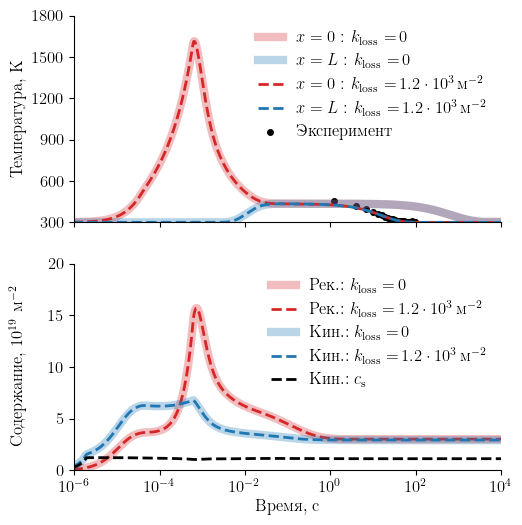

In [16]:
line_styles = ["solid", "dashed"]
line_widths = [6, 2]
alphas = [0.3, 1.0]
alpha = ["0", r"$1.2 \cdot 10^{3} \, \text{м}^{-2}$"]
fig, axs = plt.subplots(2, 1, figsize=(140 * mm2inch, 150 * mm2inch), sharex=True)
colors = ["tab:red", "tab:blue"]
for i, derived_quantities in enumerate(dq_results1):
    t = np.array(derived_quantities.t)

    retention = np.array(derived_quantities[0].data)
    axs[1].plot(
        t,
        retention / 1e19,
        label=rf"Рек.: $k_\mathrm{{loss}}=\,$" + alpha[i],
        lw=line_widths[i],
        color="tab:red",
        alpha=alphas[i],
        ls=line_styles[i],
    )

for i, derived_quantities in enumerate(dq_results):
    t = np.array(derived_quantities.t)
    T_front = np.array(derived_quantities[1].data)
    T_back = np.array(derived_quantities[2].data)

    retention = np.array(derived_quantities[0].data)
    cs = np.array(derived_quantities[-1].data)
    np.array(derived_quantities[-1].data)
    axs[0].plot(
        t,
        T_front,
        label=rf"$x=0:\,k_\mathrm{{loss}}=\,$" + alpha[i],
        color="tab:red",
        lw=line_widths[i],
        alpha=alphas[i],
        ls=line_styles[i],
    )
    axs[0].plot(
        t,
        T_back,
        label=rf"$x=L:\,k_\mathrm{{loss}}=\,$" + alpha[i],
        color="tab:blue",
        lw=line_widths[i],
        alpha=alphas[i],
        ls=line_styles[i],
    )

    axs[1].plot(
        t,
        (cs + retention) / 1e19,
        label=rf"Кин.: $k_\mathrm{{loss}}=\,$" + alpha[i],
        lw=line_widths[i],
        color="tab:blue",
        alpha=alphas[i],
        ls=line_styles[i],
    )
    if i == 1:
        axs[1].plot(
            t,
            (cs) / 1e19,
            label=r"Кин.: $c_\mathrm{s}$",
            ls="dashed",
            lw=2,
            color="black",
        )

exp = np.loadtxt("./reference_data/T_back_exp.csv", delimiter=",", skiprows=1)
axs[0].scatter(exp[:, 0], exp[:, 1], s=16, color="black", label="Эксперимент")

axs[0].set_xlim(1e-6, 1e4)
axs[0].set_yticks([300, 600, 900, 1200, 1500, 1800])
axs[0].set_ylim(300, 1800)
axs[0].set_xscale("log")
axs[1].set_xlabel("Время, с")
axs[0].set_ylabel("Температура, К")
axs[1].set_ylim(0, 20)
axs[1].set_ylabel(r"Содержание, $10^{19}$ м$^{-2}$")
axs[0].legend(handlelength=1.5)
axs[1].legend(handlelength=1.5)

fig.align_ylabels()
plt.savefig(
    "../../../Thesis/images/QSPA_T_ret.pdf", bbox_inches="tight", pad_inches=0.02
)
plt.show()